## SMSecure 

SMSecure è un progetto che ha come obiettivo quello di realizzare un filtro anti spam. Quindi a partire da un semplice dataset andrò ad effettuare le operazioni necessarie per trovare relazioni tra i dati, preprocessare i dati, e infine utilizzare i dati per addestrare un modello di ML.

In [420]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

leggo il dataset e stampo un campione (prime 5 righe)

In [421]:
df = pd.read_csv('sms_dataset.csv', encoding="ISO-8859-1")
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5351,ham,Yup it's at paragon... I havent decided whethe...,NaN,NaN,NaN
1327,spam,Ur balance is now å£500. Ur next question is: ...,NaN,NaN,NaN
18,ham,Fine if thatåÕs the way u feel. ThatåÕs the wa...,NaN,NaN,NaN
2031,ham,"I noe la... U wana pei bf oso rite... K lor, o...",NaN,NaN,NaN
1154,ham,Did u find a sitter for kaitlyn? I was sick an...,NaN,NaN,NaN


numero righe e colonne del dataset

In [422]:
df.shape

(5572, 5)

## Data Cleaning (rimozione varlori nulli, duplicati)

stampo le info del dataset per fare una panoramica

In [423]:
df.info

<bound method DataFrame.info of         v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN

si può notare che ci sono delle colonne inutili (ultime 3), quindi vanno eliminate

In [424]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.sample(5)

,v1,v2
2209,ham,"Hmm well, night night"
2085,ham,Moji i love you more than words. Have a rich day
5320,ham,But we havent got da topic yet rite?
178,ham,Text her. If she doesnt reply let me know so i...
2926,ham,Ok... U enjoy ur shows...


rinomino le colonne v1 e v2 con nomi migliori

In [425]:
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
df.sample(5)

,target,text
586,ham,"I dun thk i'll quit yet... Hmmm, can go jazz ?..."
2120,ham,"Argh my 3g is spotty, anyway the only thing I ..."
5069,spam,5p 4 alfie Moon's Children in need song on ur ...
2383,ham,Your pussy is perfect!
4908,ham,Will do. Have a good day


ora devo traformare il target "ham/spam" in codifica binaria 0/1 quindi ho bisogno di sickitLearn e più nello specifico di LabelEncoder che viene utilizzato per convertire etichette categoriche in numeri interi in modo che possano essere utilizzate come input per algoritmi di machine learning. 


In [426]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [427]:
df['target'] = encoder.fit_transform(df['target'])
df.sample(5)

,target,text
2383,0,Your pussy is perfect!
1925,0,We don call like &lt;#&gt; times oh. No give...
4601,0,\Hey j! r u feeling any better
1316,0,Why nothing. Ok anyway give me treat
5084,0,Hey happy birthday...


quindi ora gli spam saranno indicati come 1, gli ham come 0

controllo se sono presenti valori nulli o duplicati, e nel caso risolvo

In [428]:
df.isnull().sum()

target    0
text      0
dtype: int64

non ci sono valori nulli, procedo a verificare eventuali duplicati

In [429]:
df.duplicated().sum()

403

procedo a rimuovere i 403 duplicati

In [430]:
df = df.drop_duplicates(keep='first')

In [431]:
df.duplicated().sum()

0

ho risolto! Ora il dataset ha 0 nulli e 0 duplicati

# Data Understanding

fase in cui si esplorano, visualizzano e comprendono i dati per scoprire informazioni rilevanti, tendenze, relazioni e anomalie nei dati.

In [432]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

Quindi il mio dataset ha 4516 SMS "ham" e 653 "spam"

vado a rappresentare tale informazione usando un grafico a torta

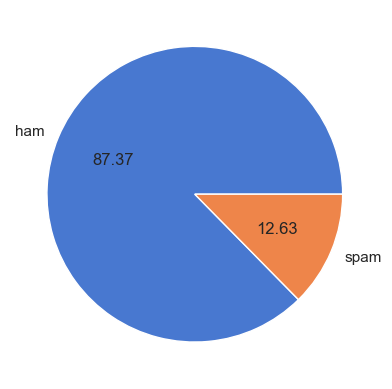

In [433]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

Quindi da tale grafico si può notare che i dati non sono bilanciati, vado ad effettuare la data preparation, il cui step finale è proprio il bilanciamento.


Vado a ricavare delle feature aggiuntive (Feature construction), in particolare dal testo dei messaggi posso ricavare il numero di frasi, il numero di parole e il numero di caratteri.

In [434]:
#ho dovuto fare tutto ciò perchè non riuscivo a effettuare il download di nltk (mi serve per ricavare le feature)
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt') 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samuelerusso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Ho scaricato la libreria Nltk Python ampiamente utilizzata per il trattamento del linguaggio naturale. Tra gli strumenti presenti, c'è il tokenizer NLTK denominato "Punkt" che viene utilizzato per la suddivisione di testo in frasi ed è molto utile quando si desidera suddividere un testo in frasi al fine di analizzarle o elaborarle in modo più dettagliato.

ora vado a vedere la lunghezza in caratteri di ogni messaggio 

In [435]:
df['text'].apply(len) 


0       111
1        29
2       155
3        49
4        61
       ... 
5567    161
5568     37
5569     57
5570    125
5571     26
Name: text, Length: 5169, dtype: int64

quindi creo una nuova colonna nel dataset in cui indico il numero di caratteri e stampo un sample per vedere che tutto ha funzionato

In [436]:
df['num_characters'] = df['text'].apply(len)
df.head()

/var/folders/zq/qftd43l52j55ztwn7drwlhl40000gn/T/ipykernel_6329/1640207782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_characters'] = df['text'].apply(len)


,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


vado ora a calcolare il numero di parole in ogni messaggio, utilizzando il tokenizer della libreria nltk. Vado anche qui a creare una colonna.

In [437]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

/var/folders/zq/qftd43l52j55ztwn7drwlhl40000gn/T/ipykernel_6329/4195423815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))


,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


vado ora a calcolare il numero di frasi per ogni messaggio e metto i dati in una nuova colonna

In [438]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

/var/folders/zq/qftd43l52j55ztwn7drwlhl40000gn/T/ipykernel_6329/2347695044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))


,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


stampo un grafico che mi faccia vedere le differenze di caratteri tra sms ham/spam.

<Axes: xlabel='num_characters', ylabel='Count'>

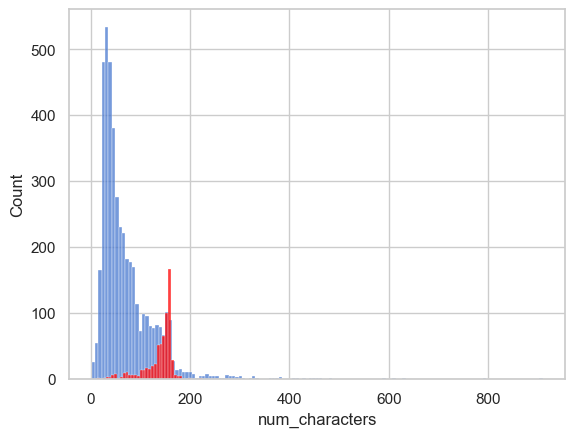

In [439]:
import seaborn as sns
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target']==1]['num_characters'], color='red')


Quindi si può notare che i messaggi spam in media hanno un numero di caratteri abbastanza alto.

Ora vado a stampare lo stesso tipo di grafico, ma per il numero di parole.

<Axes: xlabel='num_words', ylabel='Count'>

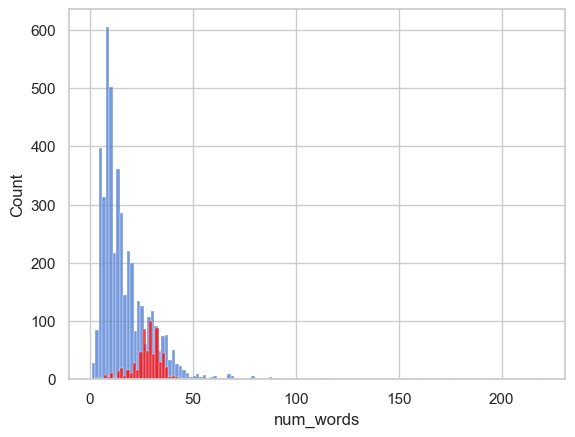

In [440]:
sns.histplot(df[df['target']==0]['num_words'])
sns.histplot(df[df['target']==1]['num_words'], color='red')

Inoltre come si può notare da tale grafico, i messaggi spam hanno in media anche un numero di parole abbastanza alto (difatti numero words e numero caratteri sono correlati come si può ben pensare). Mentre nei messagi legittimi (ham) il numero di words è spesso più basso.

Ora stampo un grafico riassuntivo, un pairplot.
In un pairplot, ciascuna variabile numerica presente nel dataset viene confrontata con tutte le altre variabili numeriche tramite grafici a dispersione, quindi consentono di visualizzare e individuare eventuali relazioni o tendenze tra le variabili.

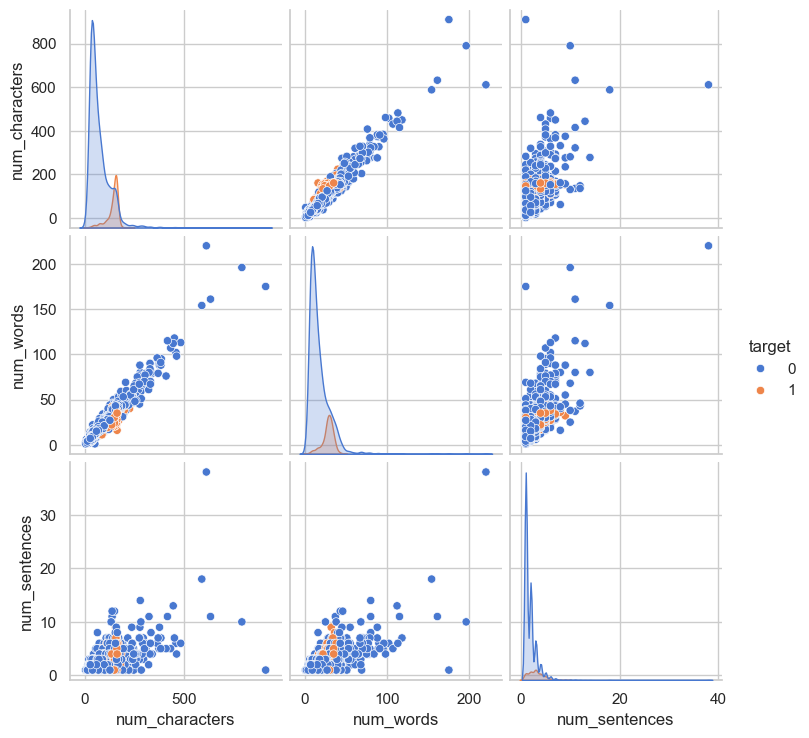

In [441]:
sns.pairplot(df, hue='target')

Emerge dal pairplot:
- sms spam hanno in media un numero di caratteri maggiore dei messaggi ham
- sms spam hanno in media un numero di word maggiore rispetto ai messaggi ham
- il numero di frasi è invece prevalentemente maggiore negli sms ham.

Vado a visualizzare gli stessi dati con la matrice di correlazione, che mi restituisce le correlazioni tra le variabili del dataset, prima di fare ciò devo escludere dal dataframe la colonna text

In [442]:
df_without_text = df.drop(columns=["text"])
df_without_text.corr()

,target,num_characters,num_words,num_sentences
target,1.000000,0.384717,0.262912,0.263939
num_characters,0.384717,1.000000,0.965760,0.624139
num_words,0.262912,0.965760,1.000000,0.679971
num_sentences,0.263939,0.624139,0.679971,1.000000


vado a rappresentare tali valori con una heatmap che utilizza colori per visualizzare i valori dei coefficienti di correlazione tra le diverse coppie di variabili nel dataset, consentendo di individuare facilmente relazioni tra di esse.
All'interno della mappa:
- Le celle più scure o più chiare indicano correlazioni più forti o più deboli, rispettivamente. 
- le variabili che sono fortemente correlate tra loro (valori vicini a 1 o -1) o variabili che hanno una bassa correlazione (valori vicini a 0).

<Axes: >

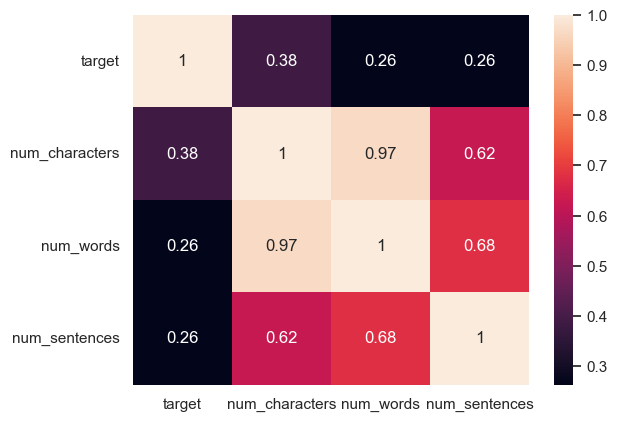

In [443]:
sns.heatmap(df_without_text.corr(), annot=True)

Dalla heatmap emergono svariate considerazioni facilemente spiegabili: 
- forte correlazioni tra numero di parole e numero di caratteri


# Data preparation (Data cleaning)

Rientra nella fase di pulizia dei dati, e vado ad eseguire i seguenti passaggi:
- portare tutto il testo in miniscolo
- tokenizzazione
- rimozione caratteri speciali
- rimozione punteggiatura e stopwords
- stemming (sostituire le parole con la loro radice)

Creo una funzione che esegua tutti questi passi, che prenda in input del testo, e mi restituisca in output del testo preprocessato, ovvero minuscolo, tokenizzato, senza caratteri speciali e stopword, con tutte le words riporatte alla forma base.

In [444]:
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#stemmer utilizzato per ridurre le parole alla loro forma di base (stemma/radice).
ps = PorterStemmer() 



def transform_text(text):
    text = text.lower() #trasforma tutto in minuscolo per una maggiore coerenza durante l'analisi
    text = nltk.word_tokenize(text) #Utilizza la tokenizzazione per suddividere il testo in una lista di parole (token).
    
    #Rimuove i caratteri non alfanumerici (simboli che non sono né lettere dell'alfabeto né numeri) mantenendo solo le parole alfanumeriche.
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    # Rimuove le stopwords (parole comuni senza un significato specifico) e la punteggiatura.
    #Le stopwords sono parole comuni considerate insignificanti ai fini dell'analisi del testo perché sono molto frequenti in una lingua, ma portano con sé poco significato (come gli articoli, le preposizioni, le congiunzioni ecc. ).
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    #Esegue lo stemming delle parole (riduzione alla forma base/radice utile per ridurre le variazioni delle parole semplificando così l'analisi del testo
    for i in text:
        y.append(ps.stem(i))
    
    #Restituisce il testo pre-elaborato come una stringa di parole separate tra spazi.        
    return " ".join(y)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samuelerusso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


test funzione su più frasi:

In [445]:
transform_text('"Data scientists use tools like Python, R, and SQL to analyze large datasets, employing machine learning algorithms to extract valuable insights and patterns!"')

'data scientist use tool like python r sql analyz larg dataset employ machin learn algorithm extract valuabl insight pattern'

In [446]:
transform_text('URGENT!! 🚨 Your 100 % FREE PRIZE awaits! Claim NOW by texting "WIN" to 555-1234. Don t miss this EXCLUSIVE offer! 🎁🌟')

'urgent 100 free prize await claim text win miss exclus offer'

Ora procedo a trasformare il testo di tutti gli sms presenti nel dataset, e li inserisco in una nuova colonna.


In [447]:
df['text'].apply(transform_text)

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri 2 wkli comp win fa cup final tkt 21...
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
                              ...                        
5567    2nd time tri 2 contact u pound prize 2 claim e...
5568                                b go esplanad fr home
5569                                    piti mood suggest
5570    guy bitch act like interest buy someth els nex...
5571                                       rofl true name
Name: text, Length: 5169, dtype: object

In [448]:
df['transformed_text'] = df['text'].apply(transform_text)

/var/folders/zq/qftd43l52j55ztwn7drwlhl40000gn/T/ipykernel_6329/87086937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transformed_text'] = df['text'].apply(transform_text)


In [449]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


Ora che ho pulito i dati, vado a plottare alcuni grafici per capire quali sono le words più ricorrenti nelle classi ham/spam, per avere idea di quali saranno le parole che impatteranno la predizione di un sms ham/spam.

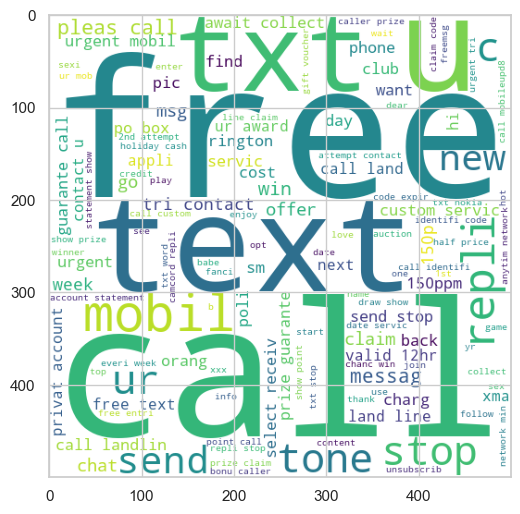

In [450]:
#utilizzo la libreria WordCLoud
from wordcloud import WordCloud

wc= WordCloud(width=500, height=500, min_font_size=10, background_color='white')

spam_words = wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(15, 6))
plt.imshow(spam_words)

Qui sopra ci sono le parole più diffuse nei testi si sms spam.
Ora vado a ricavare lo stesso grafico per gli sms ham.

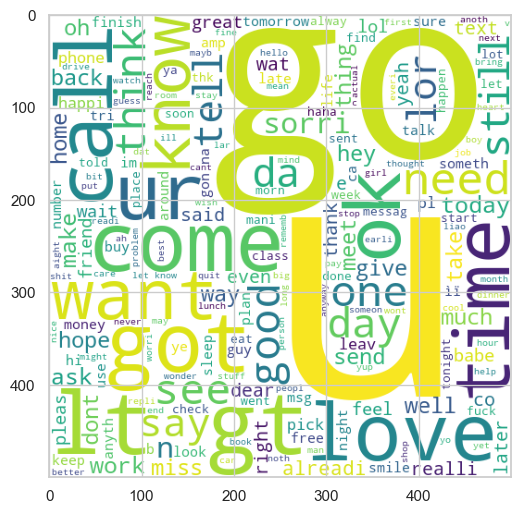

In [451]:
ham_words = wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.imshow(spam_words)

Quindi da questi due grafici va ad emergere quali sono le parole più diffuse negli sms ham/spam, quindi il classificatore andrà anche a basarsi sulla ricorrenza di tali parole per andare a classificare un sms.


## Data Preparation (Feature scaling)

Da come emerge, le scale fra numero di caratteri, numero di parole e numero di frasi sono diverse... quindi vado a normalizzare i vari valori utilizzando la tecnica più diffusa: min max normalization.

In [452]:
from sklearn.preprocessing import MinMaxScaler

#colonne che voglio normalizzare
features_to_normalize = ['num_characters', 'num_words', 'num_sentences']

#oggetto che permette la normalizzazione
scaler = MinMaxScaler() 

df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])



/var/folders/zq/qftd43l52j55ztwn7drwlhl40000gn/T/ipykernel_6329/2238337957.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])


Stampo un campione per vedere se tutto ha avuto successo.

In [453]:
df.sample(10)

,target,text,num_characters,num_words,num_sentences,transformed_text
3247,0,Also track down any lighters you can find,0.042952,0.031963,0.000000,also track lighter find
4169,0,"Mmmmmm ... I love you,so much, Ahmad ... I can...",0.170705,0.178082,0.108108,mmmmmm love much ahmad ca wait year begin ever...
4395,0,Dear :-/ why you mood off. I cant drive so i b...,0.064978,0.068493,0.027027,dear mood cant drive brother drive
3816,0,This is my number by vivek..,0.028634,0.027397,0.000000,number vivek
576,0,I'm tired of arguing with you about this week ...,0.117841,0.123288,0.027027,tire argu week week want
720,0,Oh is it? Send me the address,0.029736,0.031963,0.027027,oh send address
4029,0,"Cool, I'll text you in a few",0.028634,0.036530,0.000000,cool text
75,0,I am waiting machan. Call me once you free.,0.045154,0.045662,0.027027,wait machan call free
2042,0,"Me not waking up until 4 in the afternoon, sup",0.048458,0.045662,0.000000,wake 4 afternoon sup
1602,0,Ok pa. Nothing problem:-),0.025330,0.031963,0.027027,ok noth problem


Come si può notare ora tutto è normalizzato

# Data Preparation (Feature Selection)

Si può notare che num_sentences assumeva già prima della feature scaling un valore quasi sempre uguale e con un rande molto limitato, quindi è una feature a bassa varianza... di conseguenza è una feature poco predittiva quindi procedo ad eliminarla.

In [454]:
df = df.drop('num_sentences', axis=1) #axis=1 vuol dire colonne, axis=0 righe

#stampo un sample per vedere se è tutto ok
df.sample(5)

,target,text,num_characters,num_words,transformed_text
366,1,"Update_Now - Xmas Offer! Latest Motorola, Sony...",0.179515,0.127854,xma offer latest motorola sonyericsson nokia f...
376,0,You could have seen me..i did't recognise you ...,0.056167,0.059361,could seen recognis face
4701,0,Anytime...,0.008811,0.004566,anytim
2336,0,\Aww you must be nearly dead!Well Jez isComing...,0.103524,0.091324,must nearli dead well jez iscom todo workand w...
4108,0,I want to lick your pussy now...,0.033040,0.031963,want lick pussi


# Data Preparation (Data Balancing )

provo a bilanciare i dati, andando a fare un clustering. Dopo aver eseguito il clustering, ed avere individuato i migliori clustering, ovvero quelli più rappresentativi grazie silhouette, vado a selezionare un pò di dati da questi cluster.
L'indice silhouette è una misura usata per valutare la qualità della clusterizzazione dei dati in un problema di clustering. È spesso utilizzato per valutare quanto bene i dati sono stati assegnati ai cluster.

Il punteggio silhouette varia da -1 a 1, dove:

- Valori vicini a 1 indicano che il campione è stato assegnato correttamente al cluster.
- Valori vicini a 0 indicano che il campione è vicino ai confini tra due cluster.
- Valori vicini a -1 indicano che il campione è stato assegnato erroneamente al cluster sbagliato.
- In generale, un valore silhouette più alto è indicativo di una migliore clusterizzazione.  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/zq/qftd43l52j55ztwn7drwlhl40000gn/T/ipykernel_6329/3607282907.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ham['cluster'] = kmeans.fit_predict(ham['text'].str.len().values.reshape(-1, 1))


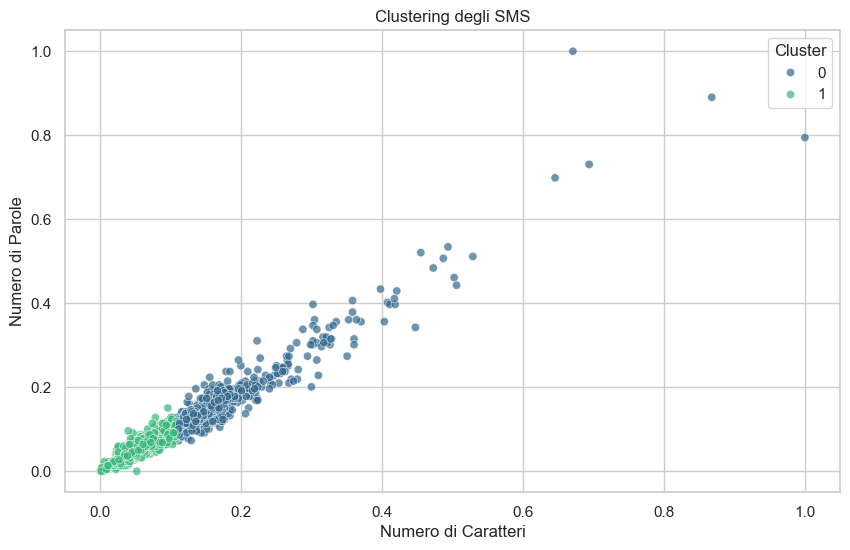

Silhouette Score Medio per tutti i cluster: 0.6891070745060113
Silhouette Score per Cluster 0: 0.5025812842854496
Silhouette Score per Cluster 1: 0.7404661949423422


In [455]:
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import silhouette_samples, silhouette_score

# Divido il dataframe in due parti separate ham/spam
ham = df[df['target'] == 0]
spam = df[df['target'] == 1]

# Eseguo il clustering dei campioni "ham" con K-Means (ML non supervisionato)
num_clusters = 2  # ho scelto un numero di cluster in base ai valori medi della silhouette
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
ham['cluster'] = kmeans.fit_predict(ham['text'].str.len().values.reshape(-1, 1))

# Creo un grafico a dispersione con seaborn
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x="num_characters", y="num_words", hue="cluster", data=ham, palette="viridis", alpha=0.7)
plt.xlabel('Numero di Caratteri')
plt.ylabel('Numero di Parole')
plt.title('Clustering degli SMS')
plt.legend(title='Cluster')
plt.show()

# Calcolo il valore della Silhouette per ciascun campione
sample_silhouette_values = silhouette_samples(ham['text'].str.len().values.reshape(-1, 1), ham['cluster'])

# Calcola la Silhouette Score media per tutti i campioni nella classe "ham"
silhouette_avg = silhouette_score(ham['text'].str.len().values.reshape(-1, 1), ham['cluster'])
print(f"Silhouette Score Medio per tutti i cluster: {silhouette_avg}")

# Stampa il Silhouette Score per ogni singolo cluster, cluster_mask è una maschera booleana e serve per selezionare gli elementi corrispondenti al cluster specifico. 
for cluster_id in range(num_clusters):
    cluster_mask = (ham['cluster'] == cluster_id)
    cluster_silhouette_avg = silhouette_avg if cluster_mask.sum() == 0 else sample_silhouette_values[cluster_mask].mean()
    print(f"Silhouette Score per Cluster {cluster_id}: {cluster_silhouette_avg}")

# Eseguo l'undersampling dai tutti i cluster, ovvero prendo solo un tot di righe da essi.
undersampled_ham = pd.DataFrame()  # creo un nuovo dataframe

num_samples_per_cluster = 325  # Numero di campioni da campionare da ciascun cluster

# vado a selezionare 320 campioni da ogni cluster
for cluster_id in range(num_clusters):
    cluster_samples = ham[ham['cluster'] == cluster_id]
    #if cluster_id == 2:
        #num_samples_per_cluster = 74
    # Eseguo l'undersampling (campiona da ciascun cluster)
    cluster_samples = resample(cluster_samples, replace=False, n_samples=num_samples_per_cluster, random_state=42)
    # Aggiungo i campioni campionati all'insieme di campioni sottocampionati
    undersampled_ham = pd.concat([undersampled_ham, cluster_samples])

# Combina l'undersampled classe "ham" con il dataframe che contiene la classe "spam" per ottenere il dataset bilanciato
df_undersampled = pd.concat([undersampled_ham, spam])

# Ora df_undersampled contiene il dataset bilanciato, quindi copio in variabile df, ovvero il df che uso di default.
df = df_undersampled

Basandomi sui punteggi della Silhouette Score medio ho considerato opportuno fare la divisione in soli due cluster, dato che ho ottenuto valori di silhouette score medio più alto, nonchè risultati migliori in termini di accuratezza e precisione.


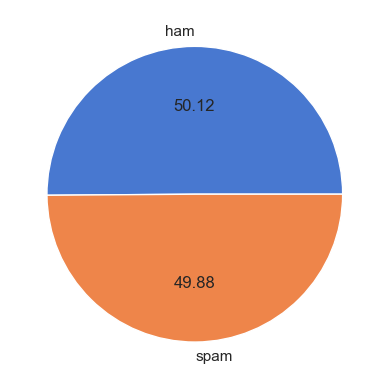

In [456]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

In [457]:
df['target'].value_counts()

target
1    653
0    650
Name: count, dtype: int64

In [458]:
#ora posso andare copiare tutto su df, eliminando la colonna cluster dato che non mi servirà più
df = df_undersampled.drop(columns=['cluster'])
df.sample(5)

,target,text,num_characters,num_words,transformed_text
3333,0,"That's fine, have him give me a call if he kno...",0.089207,0.086758,fine give call know want question
2876,0,twenty past five he said will this train have ...,0.111233,0.095890,twenti past five said train durham alreadi coz...
4247,1,"accordingly. I repeat, just text the word ok o...",0.079295,0.068493,accordingli repeat text word ok mobil phone send
4059,1,This weeks SavaMob member offers are now acces...,0.172907,0.136986,week savamob member offer access call 08709501...
3220,1,"Thanks for your ringtone order, reference numb...",0.170705,0.118721,thank rington order refer number x29 mobil cha...


Ora posso passare alla fase di modeling, ovvero scelta algortimo e addestramento modello.
Ma prima vado ad elimnare il campo 'text' dato che non mi servirà più.

In [459]:
df = df.drop(['text'], axis=1)
df.head()

,target,num_characters,num_words,transformed_text
977,0,0.229075,0.200913,dont hesit know second time weak like keep not...
4407,0,0.309471,0.228311,take care sleep need learn chang need get conv...
857,0,0.147577,0.155251,hai ana tomarrow come morn lt decim gt ill sat...
2484,0,0.134361,0.136986,promis get soon text morn let know made ok
341,0,0.164097,0.155251,take post come must 1000 text happi read one w...


## Modeling 

Per prima cosa vado a trasformare i dati in dati numerici che possono esserre "dati in pasto" ad un classificatore e dividere i dati in train set e test set.

In [460]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix

# Estraggo le feature del testo e le trasformo in rappresentazione numerica con il tfid
text_feature = 'transformed_text'
tfidf = TfidfVectorizer(max_features=3000)
text_vectorizer = tfidf.fit_transform(df[text_feature])

# Estraggo le altre feature (rimuovo quindi testo ed etichetta)
other_features = df.drop(['transformed_text', 'target'], axis=1) 

# Combino le rappresentazioni delle feature
X_combined = hstack([text_vectorizer, csr_matrix(other_features)])

# Divido i dati (train set e test set)
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=2)


A questo punto, una volta che i dati sono pronti per essere processati da un algortimo, e ho diviso i miei dati in due insiemi distinti (dati training e dati test), posso procedere a selezionare uno o più algortimi, e quindi a costruire il modello.

# Naive Bayes

In [461]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score

Come primo algoritmo ho scelto Naive Bayes, che però è presente con distribuzioni differenti (bernoulli, multinomiale, gaussiana) che si differenziano per la natura dei dati che sono progettati per trattare.
Naive Bayes:
- GaussianNB (Naive Bayes Gaussiano), datto per dati continui e spesso utilizzato quando le feature del dataset sono numeriche.
- MultinomialNB (Naive Bayes Multinomiale), utilizzato per dati discreti, come conteggi di parole e spesso utilizzato per problemi di classificazione di testi, dove le feature sono rappresentazioni di conteggio delle parole o frequenze delle parole
- BernoulliNB (Naive Bayes di Bernoulli), adatto per dati dove sono presento feature booleane, spesso utilizzato in problemi di classificazione con dati binari, come la classificazione di documenti come spam o non-spam.

Quindi emerge che probabilmente la distribuzione gaussiana è quella che meglio si presta nel mio caso, vado quindi ad approfindire eseguendo il train su ognuno dei 3 modelli con gli stessi dati di training e di test.


In [462]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

Naive Bayes MNB (Multinomial)

Accuracy:  0.9662576687116564
Precision:  0.9698795180722891
Recall:  0.9640718562874252


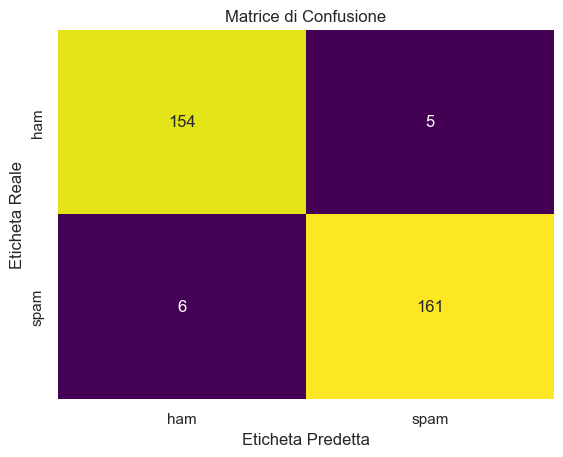

In [463]:
#procedo ad addestrare il modello sui dati di training

mnb.fit(X_train,y_train)

#predizioni 
y_pred = mnb.predict(X_test)
accuracyMNB = accuracy_score(y_test,y_pred)
precisionMNB = precision_score(y_test,y_pred)
recallMNB = recall_score(y_test, y_pred)

print('Accuracy: ' ,accuracyMNB)
print('Precision: ' ,precisionMNB)
print('Recall: ' ,recallMNB)

#plot della matrice di confusione
labels = ['ham', 'spam']
confusion_matrix_result = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels, cbar=False)
plt.title('Matrice di Confusione')
plt.xlabel('Eticheta Predetta')
plt.ylabel('Eticheta Reale')
plt.show()

Naive Bayes GNB (Gaussian)

Accuracy:  0.941717791411043
Precision:  0.9352941176470588
Recall:  0.9520958083832335


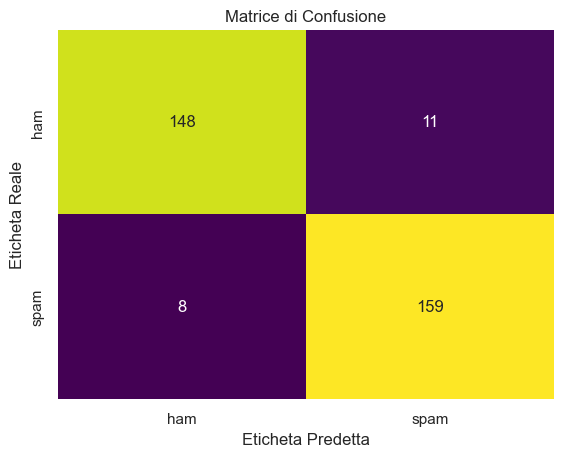

In [464]:
gnb.fit(X_train.toarray(),y_train) #training 
y_pred1 = gnb.predict(X_test.toarray()) #testing
accuracyGNB = accuracy_score(y_test,y_pred1)
precisionGNB = precision_score(y_test,y_pred1)
recallGNB = recall_score(y_test,y_pred1)
print('Accuracy: ' , accuracyGNB)
print('Precision: ' , precisionGNB)
print('Recall: ' , recallGNB)

#plot della matrice di confusione
labels = ['ham', 'spam']
confusion_matrix_result = confusion_matrix(y_test,y_pred1)
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels,cbar=False)
plt.title('Matrice di Confusione')
plt.xlabel('Eticheta Predetta')
plt.ylabel('Eticheta Reale')
plt.show()


Naive Bayes BNB (Bernoulli)

Accuracy:  0.9447852760736196
Precision:  0.9933774834437086
Recall:  0.8982035928143712


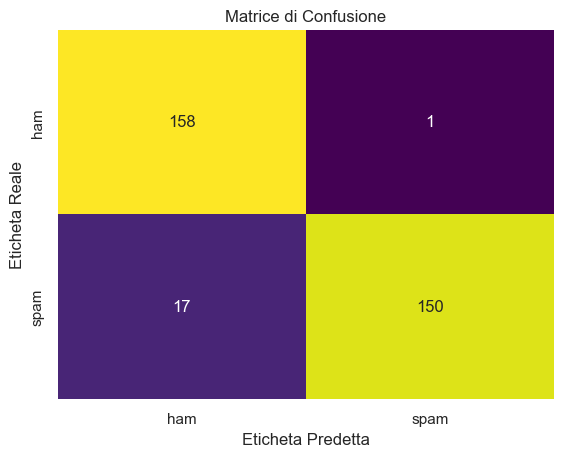

In [465]:
bnb.fit(X_train,y_train) #training modello
y_pred3 = bnb.predict(X_test) #test modello
accuracyBNB = accuracy_score(y_test,y_pred3)
precisionBNB = precision_score(y_test,y_pred3)
recallBNB = recall_score(y_test,y_pred3)

print('Accuracy: ' ,accuracyBNB)
print('Precision: ' ,precisionBNB)
print('Recall: ' ,recallBNB)

#plot della matrice di confusione
labels = ['ham', 'spam']
confusion_matrix_result = confusion_matrix(y_test,y_pred3)
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels, cbar=False)
plt.title('Matrice di Confusione')
plt.xlabel('Eticheta Predetta')
plt.ylabel('Eticheta Reale')
plt.show()


Quindi da come emerge dai vari test, il naive bayes si comporta bene.

Vado ora a provare l'utilizzo di un ulteriore algortimo visto nelle lezioni sulla classificazioni, ovvero gli alberi decisionali

# Alberi decisionali (Decision Tree Classifier)

Gli alberi decisionali sono algoritmi di apprendimento supervisionato utilizzati per la classificazione, l'obiettivo principale è quello di creare un modello che possa prendere decisioni basate su una serie di domande poste sulle feature dei dati.

Funzionamento in breve:
- L'algoritmo inizia selezionando la feature che migliora maggiormente la separazione dei dati in classi omogenee. 
- Il nodo viene diviso in base ai valori possibili della feature selezionata.
- ripeti

In [466]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=8)

Accuracy:  0.8680981595092024
Precision:  0.918918918918919
Recall:  0.8143712574850299


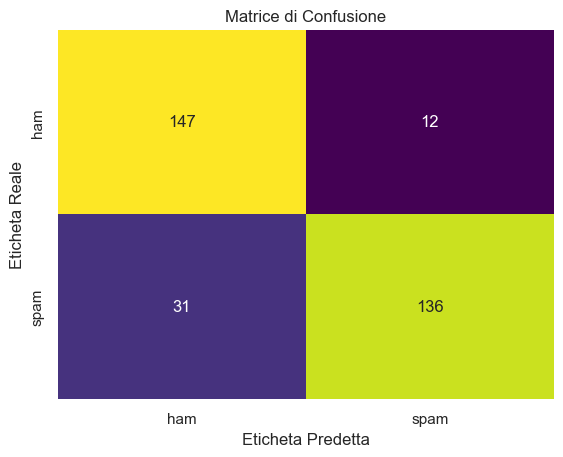

In [467]:
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)
accuracyDTC = accuracy_score(y_test,y_pred)
precisionDTC = precision_score(y_test,y_pred)
recallDTC = recall_score(y_test,y_pred)

print('Accuracy: ' ,accuracyDTC)
print('Precision: ' ,precisionDTC)
print('Recall: ' ,recallDTC)

#plot della matrice di confusione
labels = ['ham', 'spam']
confusion_matrix_result = confusion_matrix(y_test,y_pred)
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels, cbar=False)
plt.title('Matrice di Confusione')
plt.xlabel('Eticheta Predetta')
plt.ylabel('Eticheta Reale')
plt.show()

Ho eseguito l'algortimo più volte, andando a variare il parametro di profondità massima degli alberi generati, e ho osservato che le performance in termini di precisione/accuratezza salgono fino ad una depth pari ad 8, per poi andare in stallo.
Tuttavia, come si può notare, ho ottenuto dei risultati di gran lunga migliori utilizzando naive Bayes, in particolare il naive bayes MNB, ovvero con distribuzione multinomiale. 

In generale ho ottenuto i seguenti risultati:

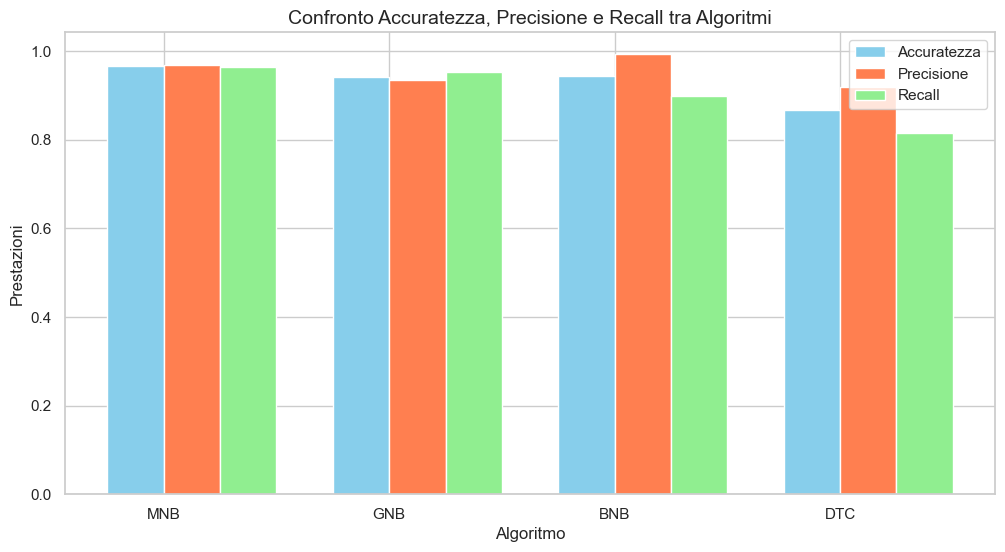

In [468]:
algorithms = ['MNB', 'GNB', 'BNB', 'DTC']

# Risultati delle prestazioni
accuracy_results = [accuracyMNB, accuracyGNB, accuracyBNB, accuracyDTC]
precision_results = [precisionMNB, precisionGNB, precisionBNB, precisionDTC]
recall_results = [recallMNB, recallGNB, recallBNB, recallDTC]

# Larghezza delle barre
bar_width = 0.25

# Posizioni delle barre
index = np.arange(len(algorithms))

# Creo un grafico a barre doppie
plt.figure(figsize=(12, 6))
bar1 = plt.bar(index, accuracy_results, bar_width, label='Accuratezza', color='skyblue')
bar2 = plt.bar(index + bar_width, precision_results, bar_width, label='Precisione', color='coral')
bar3 = plt.bar(index + 2 * bar_width, recall_results, bar_width, label='Recall', color='lightgreen')

# Personalizzo il grafico con i nomi delle label e dimensione font
plt.xlabel('Algoritmo', fontsize=12)
plt.ylabel('Prestazioni', fontsize=12)
plt.title('Confronto Accuratezza, Precisione e Recall tra Algoritmi', fontsize=14)
plt.xticks(index + bar_width / 2, algorithms)
plt.legend()

#eseguo
plt.show()

Quindi da come emerge, ho ottenuto buoni risultati con il naive Bayes, mentre i risultati sono peggiori con il DTC.
Se considero tutti gli indicatori, i migliori son sicuramente il nayve Bayes Multinomiale (MNB) e quello Binomiale (BNB) che difatti si prestano molto bene a problemi di classificazione del testo.

In particolare le metriche:
- 'precisione' rappresenta la frazione di istanze classificate come "spam" che sono effettivamente spam. Questa metrica è importante quando è fondamentale evitare falsi positivi.
- 'recall' misura la frazione di messaggi "spam" che il modello è in grado di identificare correttamente. È importante quando è cruciale catturare il maggior numero possibile di casi di spam, anche a costo di alcuni falsi positivi.
- 'accuratezza' misura la frazione di predizioni corrette rispetto al totale delle predizioni.

Nel mio caso dato che il dataset è bilanciato, l'accuratezza esprime la frazione di predizioni corrette in maniera giusta, quindi è da tenere in considerazione. Inoltre dato che nel mio problema è importante classificare quanti più messsaggi possibili nella classe spam, perchè spesso gli utenti non vogliono mai ricevere messaggi spam, anche a costo di qualche messaggio ham classificato erroneamente.
Sulla base di tali osservazioni decido di andare ad utilizzare il modello che utilizza il classificatore naive bayes MNB.


Stampo la curva ROC-AUC per il naive Bayes MNB.
La curva ROC (Receiver Operating Characteristic) è uno strumento grafico che viene utilizzato per valutare le prestazioni di un modello di classificazione binaria su un insieme di dati. La curva ROC rappresenta la trade-off tra la sensibilità (true positive rate) e la specificità (true negative rate) del modello al variare della soglia di decisione.
Dove:
- Sensibilità (True Positive Rate, TPR): Rappresenta la percentuale di casi positivi correttamente classificati dal modello rispetto al totale dei casi positivi reali. È anche chiamata recall o tasso di vera positività.

- Specificità (True Negative Rate, TNR): Rappresenta la percentuale di casi negativi correttamente classificati dal modello rispetto al totale dei casi negativi reali.


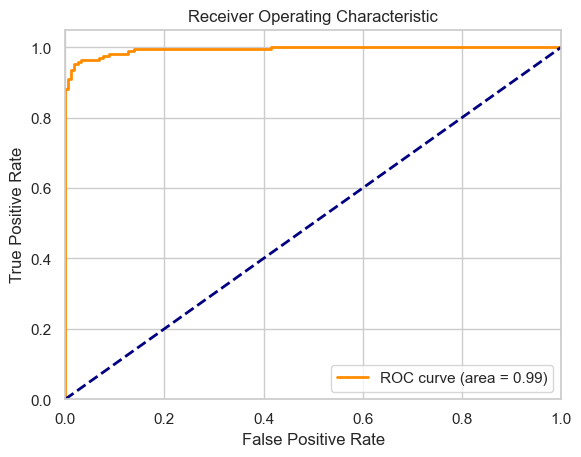

In [469]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, mnb.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Un classificatore ideale avrà una curva ROC che si avvicina il più possibile all'angolo in alto a sinistra del grafico, indicando una sensibilità elevata e una specificità elevata.

Inoltre, l'area sotto la curva ROC (Area Under the Curve, AUC-ROC) è spesso calcolata come una singola metrica riassuntiva delle prestazioni del modello. Un AUC-ROC maggiore indica generalmente una migliore capacità del modello di discriminare tra le classi.